# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.sample(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
72967,156151230,58033449,Caucasian,Male,[80-90),?,1,1,7,8,CM,?,592,599|250,0,2,0,33,8,10,3,47918-902,None,None,No,NO
116928,259657188,27981828,Caucasian,Male,[50-60),?,3,1,1,1,PO,Radiologist,414,401|593,0,0,0,46,9,10,6,68071-1701,None,Norm,Ch,<30
111886,244831488,42329592,Caucasian,Female,[90-100),?,1,1,7,1,?,InternalMedicine,250.8,599|331,0,0,0,55,8,7,0,NaN,None,None,No,<30
66606,147889758,18594522,Caucasian,Female,[80-90),?,1,3,7,3,?,InternalMedicine,808,428|492,0,0,0,58,8,17,0,47918-891,None,Norm,Ch,NO
85726,172636902,52247736,Asian,Male,[40-50),?,1,1,7,4,DM,?,572,578|286,0,0,0,47,9,11,0,68071-1701,None,None,Ch,NO
87572,175648950,91210707,Caucasian,Female,[60-70),?,1,1,7,2,DM,Nephrology,461,381|250,0,0,0,34,3,10,0,0173-0861,None,None,Ch,NO
45596,106548636,99386244,Caucasian,Female,[60-70),?,6,20,1,8,?,Emergency/Trauma,577,198|197,0,0,0,53,9,24,1,0173-0863,None,None,Ch,NO
11510,39048468,20589156,Caucasian,Male,[50-60),?,1,5,7,2,?,Family/GeneralPractice,410,E942|414,0,0,0,57,7,12,0,NaN,None,None,No,NO
114910,253757238,73513656,Caucasian,Male,[60-70),?,1,1,7,6,MC,?,415,483|799,0,0,0,54,9,24,0,0591-0460,None,None,Ch,>30
32459,82731096,74278386,Caucasian,Male,[80-90),?,1,1,7,3,?,?,458,593|414,0,1,0,34,9,9,0,NaN,None,None,No,>30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [7]:
print('# Rows: ', len(df))
print('# Unique encounter_id: ', df['encounter_id'].nunique())
print('# Unique patient_nbr: ', df['patient_nbr'].nunique())


# Rows:  143424
# Unique encounter_id:  101766
# Unique patient_nbr:  71518


Since Total # rows > Unique Encounters, this dataset is at the Line Level

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response:

**what level is this dataset? Is it at the line or encounter level?**
* This dataset is at the **Line Level** because a number of rows in the dataset is greater that a number of total rows

**Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on?**
* We should also aggregate this dataset on the **primary_diagnosis_code** field in addition to the **encounter_id** and **patient_nbr** fields


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

a. Field(s) with high amount of missing/zero values

Note that there are columns with '?'. Those are missing values.
Let's replace those ?'s with NaN

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [9]:
# df_clean = df.replace('?', np.nan)
df_clean = df.copy()

In [10]:
df_clean.isna().sum().sort_values(ascending=False)

ndc_code                    23462
readmitted                      0
medical_specialty               0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
primary_diagnosis_code          0
change                          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
max_glu_serum                   0
A1Cresult                       0
encounter_id                    0
dtype: int64

**Answer:**

The fields with missing values are (sorted descendingly):
* weight:                      139122
* medical_specialty:            69463
* payer_code:                   54190
* ndc_code:                     23462
* race:                          3309
* primary_diagnosis_code:          33

b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?


In [11]:
cols_numerics = ['number_outpatient', 'number_inpatient', 
                'number_emergency', 'num_lab_procedures',
                'number_diagnoses', 'num_medications', 
                'num_procedures', 'time_in_hospital']

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

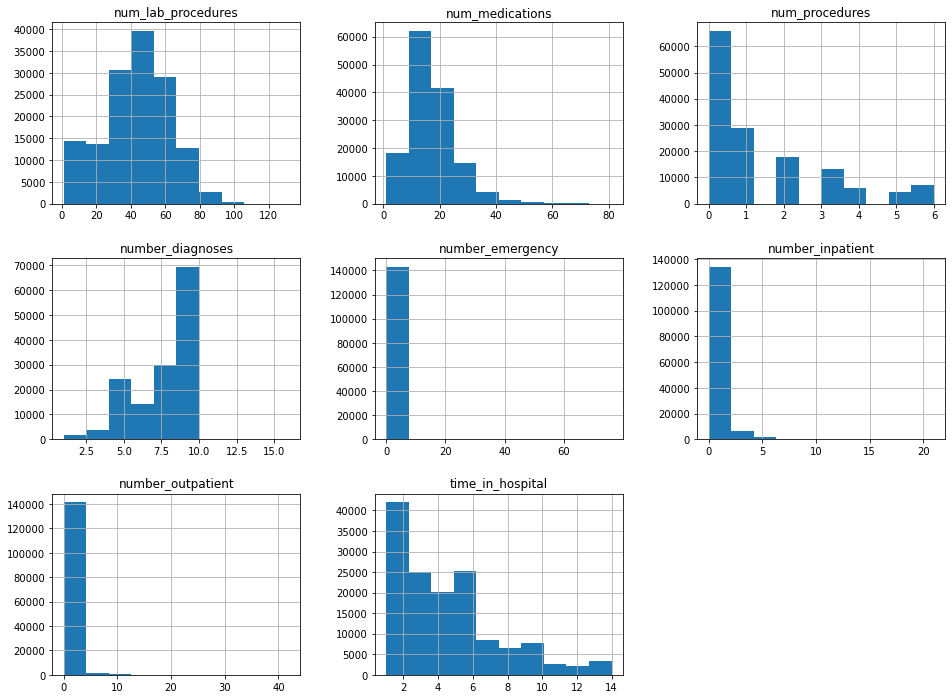

In [12]:
df_clean[cols_numerics].hist(figsize=(16,12));

**Answer:**
   
Based on the histogram plots above, the **num_lab_procedures** and **num_medications** fields have a Gausian distribution shape where a distribution of the 'num_medications' is left skewed.

c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)

In [13]:
df_clean.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [14]:
cols_categorical = ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
                    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                    'payer_code', 'medical_specialty','primary_diagnosis_code', 
                    'other_diagnosis_codes','ndc_code',
                    'max_glu_serum', 'A1Cresult', 'change', 'readmitted']

In [15]:
df_clean[cols_categorical].nunique().sort_values(ascending=False)

encounter_id                101766
patient_nbr                  71518
other_diagnosis_codes        19374
primary_diagnosis_code         717
ndc_code                       251
medical_specialty               73
discharge_disposition_id        26
payer_code                      18
admission_source_id             17
weight                          10
age                             10
admission_type_id                8
race                             6
max_glu_serum                    4
A1Cresult                        4
gender                           3
readmitted                       3
change                           2
dtype: int64

**Answer:**

As shown above, the fields that are using as an identification, codes, and medical_specialty have high cardinalities:

* encounter_id :                101766
* patient_nbr :                  71518
* other_diagnosis_codes :        19374
* primary_diagnosis_code :         716
* ndc_code :                       251
* medical_specialty :               72
* discharge_disposition_id :        26
* admission_source_id :             17
* payer_code :                      17

d. Please describe the demographic distributions in the dataset for the age and gender fields.

In [16]:
import seaborn as sns

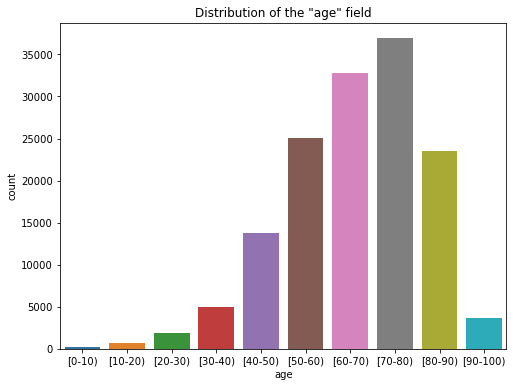

In [17]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="age", data=df_clean)
plt.title('Distribution of the "age" field');

In [18]:
df_clean['age'].value_counts()

[70-80)     36928
[60-70)     32741
[50-60)     25095
[80-90)     23527
[40-50)     13729
[30-40)      4964
[90-100)     3619
[20-30)      1927
[10-20)       733
[0-10)        161
Name: age, dtype: int64

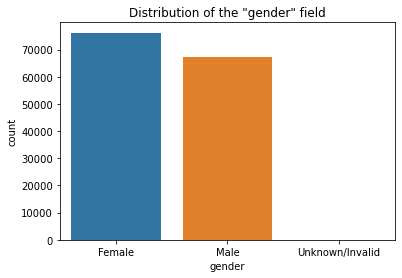

In [19]:
ax = sns.countplot(x="gender", data=df_clean)
plt.title('Distribution of the "gender" field');

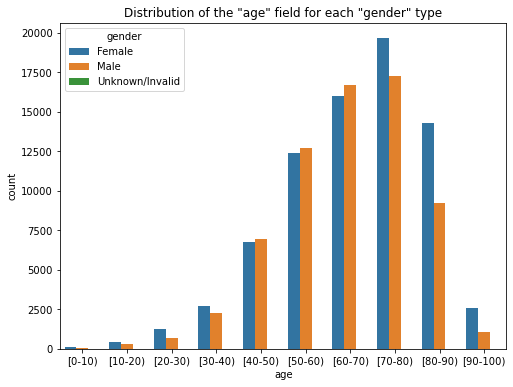

In [20]:
plt.figure(figsize=(8, 6))

ax = sns.countplot(x="age", hue="gender", data=df_clean)
plt.title('Distribution of the "age" field for each "gender" type');

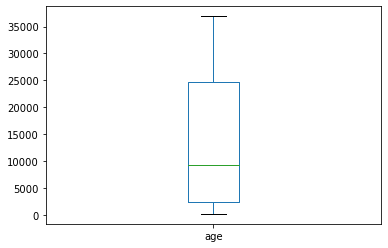

In [21]:
df_clean['age'].value_counts().plot.box();

In [22]:
df_gender_count = df_clean['gender'].value_counts()
df_gender_count

Female             76185
Male               67234
Unknown/Invalid        5
Name: gender, dtype: int64

In [23]:
print('Ratio of Female records: ', df_gender_count['Female'] / df_gender_count.sum())

Ratio of Female records:  0.5311872489959839


In [24]:
print('Ratio of Male records: ', df_gender_count['Male'] / df_gender_count.sum())

Ratio of Male records:  0.46877788933511827


**Student Response**: 

**Answer:**

* A ratio of the 'Female' and 'Male' records are closed (53% and 47% respectively)

* The **age** field has a Gausian distribution that is right skewed where the age range '[70-80)' has the most number of records

* A number of the 'Female' and 'Male' records are very closed for most age ranges except the age ranges '[70-80)', '[80-90)', and '[90-100)' where a number of 'Male' records is substantially lower than a number of 'Female' records

In [25]:
######NOTE: The visualization will only display in Chrome browser. ########
# import tensorflow_data_validation as tfdv

# full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
# tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [26]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

Explore the NDC lookup table first

In [27]:
ndc_code_df.shape

(269, 7)

In [28]:
ndc_code_df.sample(5)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
78,42291-305,Glipizide And Metformin Hydrochloride,Glipizide And Metformin Hydrochloride,"Tablet, Film Coated",Oral,"Avkare, Inc.",Human Prescription Drug
27,0781-5627,Pioglitazone And Metformin,Pioglitazone And Metformin,"Tablet, Film Coated",Oral,Sandoz Inc,Human Prescription Drug
169,43063-698,Glimepiride,Glimepiride,Tablet,Oral,"Pd-rx Pharmaceuticals, Inc.",Human Prescription Drug
44,23155-103,Metformin Hydrochloride,Metformin Hydrochloride,Tablet,Oral,Heritage Pharmaceuticals Inc.,Human Prescription Drug
180,50090-3547,Glimepiride,Glimepiride,Tablet,Oral,A-s Medication Solutions,Human Prescription Drug


Looks like we can group NDC codes using the 'Non-proprietary Name' field to reduce dimensionality

In [29]:
ndc_code_df['Non-proprietary Name'].value_counts()

Metformin Hydrochloride                       71
Glimepiride                                   55
Nateglinide                                   24
Repaglinide                                   24
Glyburide                                     18
Glipizide                                      9
Pioglitazone                                   9
Miglitol                                       9
Acarbose                                       9
Glipizide And Metformin Hydrochloride          6
Insulin Human                                  5
Pioglitazone And Glimepiride                   4
Pioglitazone Hydrochloride And Glimepiride     4
Glyburide And Metformin Hydrochloride          3
Glyburide-metformin Hydrochloride              3
Glipizide And Metformin Hcl                    3
Tolazamide                                     2
Pioglitazole And Metformin Hydrochloride       2
Rosiglitazone Maleate                          2
Pioglitazone And Metformin                     2
Pioglitazone Hcl And

We will use the first part of the 'Non-proprietary Name' to create a grouping name

In [30]:
group_props = list(ndc_code_df['Non-proprietary Name'].str.split(' ', expand = True).iloc[:, 0].unique())
group_props.remove('Glyburide-metformin')
group_props.sort()
group_props

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Human',
 'Insulin',
 'Metformin',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole',
 'Pioglitazone',
 'Repaglinide',
 'Rosiglitazone',
 'Tolazamide',
 'Tolbutamide']

In [31]:
ndc_code_df['GroupProp'] = ndc_code_df['Non-proprietary Name'].str.split(' ', expand = True).iloc[:, 0]

In [32]:
ndc_code_df.sample(5)

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type,GroupProp
68,33342-141,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Macleods Pharmaceuticals Limited,Human Prescription Drug,Metformin
25,0781-5503,Metformin Hydrochloride,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Sandoz Inc.,Human Prescription Drug,Metformin
32,0904-6691,Metformin Hydrochloride,Metformin Hydrochloride,Tablet,Oral,Major Pharmaceuticals,Human Prescription Drug,Metformin
248,0009-5014,Glyset,Miglitol,"Tablet, Film Coated",Oral,Pharmacia And Upjohn Company Llc,Human Prescription Drug,Miglitol
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug,Pioglitazone


In [33]:
ndc_code_df['GroupProp'].value_counts()

Metformin              72
Glimepiride            55
Nateglinide            24
Repaglinide            24
Pioglitazone           21
Glyburide              21
Glipizide              18
Acarbose                9
Miglitol                9
Insulin                 5
Glyburide-metformin     3
Rosiglitazone           2
Tolazamide              2
Pioglitazole            2
Human                   1
Tolbutamide             1
Name: GroupProp, dtype: int64

In [34]:
# Let's clean up a few group names
ndc_code_df['GroupProp'] = ndc_code_df['GroupProp'] \
    .replace({'Glyburide-metformin': 'Glyburide', 'Human': 'Insulin', 'Pioglitazone': 'Pioglitazole'})
ndc_code_df['GroupProp'].value_counts()

Metformin        72
Glimepiride      55
Nateglinide      24
Repaglinide      24
Glyburide        24
Pioglitazole     23
Glipizide        18
Acarbose          9
Miglitol          9
Insulin           6
Rosiglitazone     2
Tolazamide        2
Tolbutamide       1
Name: GroupProp, dtype: int64

Looks great! We will use this group name in the **generic_drug_name** column

In [35]:
from student_utils import reduce_dimension_ndc

%autoreload 2

In [36]:
# reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)
reduce_dim_df = reduce_dimension_ndc(df_clean, ndc_code_df)

Inspect the updated data frame

In [37]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,None,None,Ch,>30,Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,None,None,Ch,NO,Insulin
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,None,None,Ch,NO,Glipizide


In [38]:
reduce_dim_df['generic_drug_name'].value_counts(ascending=False)

Insulin          54383
Metformin        19988
Glipizide        12699
Glyburide        11356
Pioglitazole      7388
Rosiglitazone     6365
Glimepiride       5133
Repaglinide       1539
Nateglinide        703
Acarbose           308
Tolazamide          39
Miglitol            38
Tolbutamide         23
Name: generic_drug_name, dtype: int64

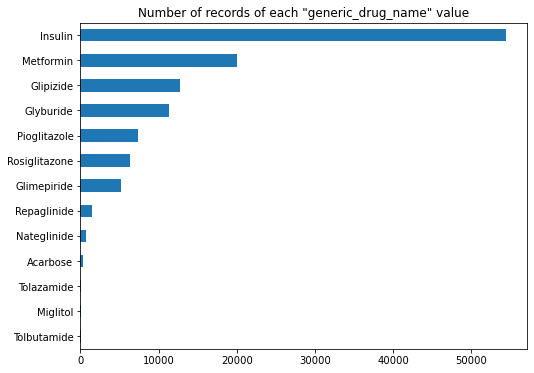

In [39]:
plt.figure(figsize=(8, 6))

reduce_dim_df['generic_drug_name'].value_counts(ascending=False).plot.barh().invert_yaxis()
plt.title('Number of records of each "generic_drug_name" value');

In [40]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [41]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [42]:
first_encounter_df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
29382,76586856,21049920,Caucasian,Female,[80-90),?,2,1,4,7,?,?,410,427|425,0,0,0,23,7,19,4,None,None,No,NO,Glyburide
142914,438993788,155001839,Asian,Female,[90-100),?,2,1,1,1,?,Nephrology,780,599|425,0,0,0,55,6,10,0,None,>8,No,NO,Glimepiride
44628,105158370,23184981,AfricanAmerican,Female,[90-100),?,1,3,5,5,?,Family/GeneralPractice,211,562|280,0,0,0,38,9,14,2,None,None,No,>30,NaN
31839,81544518,58932711,?,Female,[70-80),?,2,1,7,4,?,InternalMedicine,515,401|244,0,0,0,60,5,11,0,None,Norm,No,NO,Metformin
11026,37907184,18912411,Caucasian,Male,[50-60),?,2,18,2,13,?,?,410,427|414,0,0,0,62,7,38,6,None,None,No,NO,NaN


In [43]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [44]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [45]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Insulin',
 'Metformin',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole',
 'Repaglinide',
 'Rosiglitazone',
 'Tolazamide',
 'Tolbutamide']

In [46]:
agg_drug_df.shape

(71518, 39)

In [47]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

**Student response:**

We won't include the **medical_specialty**, **payer_code** and **weight** fields because most values in those fields are unknown

In [48]:
agg_df_replace_unknown = agg_drug_df.replace({'?': np.nan})
agg_df_replace_unknown.isna().sum().sort_values(ascending=False)

weight                      68665
medical_specialty           34477
payer_code                  31043
Insulin                     17247
Tolazamide                  17247
Glimepiride                 17247
Glipizide                   17247
Glyburide                   17247
Tolbutamide                 17247
Metformin                   17247
Miglitol                    17247
Nateglinide                 17247
Pioglitazole                17247
Repaglinide                 17247
Rosiglitazone               17247
Acarbose                    17247
race                         1948
primary_diagnosis_code         11
patient_nbr                     0
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
num_medications                 0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergen

In [49]:
# Inspect the aggregated dataframe
agg_drug_df.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glyburide,Insulin,Metformin,Miglitol,Nateglinide,Pioglitazole,Repaglinide,Rosiglitazone,Tolazamide,Tolbutamide
27255,110962620,106706124,Caucasian,Female,[20-30),?,2,1,7,5,CP,Emergency/Trauma,646,648|250.01,0,0,1,43,4,15,0,None,>8,Ch,NO,[Insulin],0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
242,2874540,7926723,AfricanAmerican,Female,[60-70),?,1,1,7,1,?,?,780,781|401,2,0,1,48,7,14,1,None,None,Ch,<30,[Insulin],0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
70457,419043704,116665916,Caucasian,Female,[60-70),?,6,6,17,12,?,?,427,486|250.02,0,0,0,74,9,34,6,None,>7,Ch,NO,"[Metformin, Glimepiride, Insulin]",0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22397,97135860,12988368,?,Male,[40-50),?,2,1,1,3,UN,?,415,?|?,0,1,0,37,2,5,0,None,None,No,NO,[Metformin],0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32299,130727658,25001694,AfricanAmerican,Female,[70-80),?,1,3,7,6,MC,InternalMedicine,560,707|599,0,0,0,40,8,5,1,None,None,No,<30,[nan],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Required categorical columns**

In [50]:
agg_drug_df['race'].value_counts()

Caucasian          53491
AfricanAmerican    12887
?                   1948
Hispanic            1517
Other               1178
Asian                497
Name: race, dtype: int64

In [51]:
agg_drug_df['gender'].value_counts()

Female             38025
Male               33490
Unknown/Invalid        3
Name: gender, dtype: int64

In [52]:
agg_drug_df['age'].value_counts()

[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: age, dtype: int64

**Selected categorical columns**

In [53]:
agg_drug_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted',
       'generic_drug_name_array', 'Acarbose', 'Glimepiride', 'Glipizide',
       'Glyburide', 'Insulin', 'Metformin', 'Miglitol', 'Nateglinide',
       'Pioglitazole', 'Repaglinide', 'Rosiglitazone', 'Tolazamide',
       'Tolbutamide'],
      dtype='object')

In [54]:
cols_categorical.remove('ndc_code')
cols_categorical

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [55]:
agg_drug_df[cols_categorical].nunique().sort_values(ascending=False)

encounter_id                71518
patient_nbr                 71518
other_diagnosis_codes       15756
primary_diagnosis_code        697
medical_specialty              71
discharge_disposition_id       26
payer_code                     18
admission_source_id            17
weight                         10
age                            10
admission_type_id               8
race                            6
max_glu_serum                   4
A1Cresult                       4
gender                          3
readmitted                      3
change                          2
dtype: int64

Since the 'primary_diagnosis_code' field has high dimensionalities, let's encode it based on the standard category groups

ICD9 Codesets:

http://www.icd9data.com/2015/Volume1/default.htm
* [-1] Unknown/ NaN
* [0] 001-139  Infectious And Parasitic Diseases
* [1] 140-239  Neoplasms
* [2] 240-279  Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders
* [3] 280-289  Diseases Of The Blood And Blood-Forming Organs
* [4] 290-319  Mental Disorders
* [5] 320-389  Diseases Of The Nervous System And Sense Organs
* [6] 390-459  Diseases Of The Circulatory System
* [7] 460-519  Diseases Of The Respiratory System
* [8] 520-579  Diseases Of The Digestive System
* [9] 580-629  Diseases Of The Genitourinary System
* [10] 630-679  Complications Of Pregnancy, Childbirth, And The Puerperium
* [11] 680-709  Diseases Of The Skin And Subcutaneous Tissue
* [12] 710-739  Diseases Of The Musculoskeletal System And Connective Tissue
* [13] 740-759  Congenital Anomalies
* [14] 760-779  Certain Conditions Originating In The Perinatal Period
* [15] 780-799  Symptoms, Signs, And Ill-Defined Conditions
* [16] 800-999  Injury And Poisoning
* [17] V01-V91  Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services
* [18] E000-E999  Supplementary Classification Of External Causes Of Injury And Poiso[1] ning

In [56]:
encoded_primary_code = []

for index, row in agg_drug_df.iterrows():
    cur_code = row['primary_diagnosis_code'][:3]
    
    encoded_code = -1
    if cur_code[0] is '8':
        encoded_code = 16
    elif cur_code[0] is 'V':
        encoded_code = 17
    elif cur_code[0] is 'E':
        encoded_code = 18
    elif cur_code[0] is '?':
        encoded_code = -1
    else:
        # The remaining values can be casted to int
        cur_code_int = int(cur_code)
        
        if cur_code_int <= 139:
            encoded_code = 0
        elif cur_code_int <= 239:
            encoded_code = 1
        elif cur_code_int <= 279:
            encoded_code = 2
        elif cur_code_int <= 289:
            encoded_code = 3
        elif cur_code_int <= 319:
            encoded_code = 4
        elif cur_code_int <= 389:
            encoded_code = 5
        elif cur_code_int <= 459:
            encoded_code = 6
        elif cur_code_int <= 519:
            encoded_code = 7
        elif cur_code_int <= 579:
            encoded_code = 8
        elif cur_code_int <= 629:
            encoded_code = 9
        elif cur_code_int <= 679:
            encoded_code = 10
        elif cur_code_int <= 709:
            encoded_code = 11
        elif cur_code_int <= 739:
            encoded_code = 12
        elif cur_code_int <= 759:
            encoded_code = 13
        elif cur_code_int <= 779:
            encoded_code = 14
        elif cur_code_int <= 799:
            encoded_code = 15
    
    encoded_primary_code.append(encoded_code)
    
agg_drug_df['primary_diagnosis_code_group'] = encoded_primary_code

In [57]:
agg_drug_df['primary_diagnosis_code_group'].value_counts()

 6     21821
 2      7685
 7      6736
 8      6403
 15     5530
 12     4080
 9      3488
 1      2742
 16     2729
-1      2355
 11     1789
 4      1548
 0      1524
 17      927
 5       876
 3       657
 10      586
 13       41
 18        1
Name: primary_diagnosis_code_group, dtype: int64

In [58]:
potential_cat_cols = ['race', 'gender', 'age', 'payer_code', 'weight', 'primary_diagnosis_code_group',
                      'A1Cresult', 'max_glu_serum', 'readmitted', 'change']

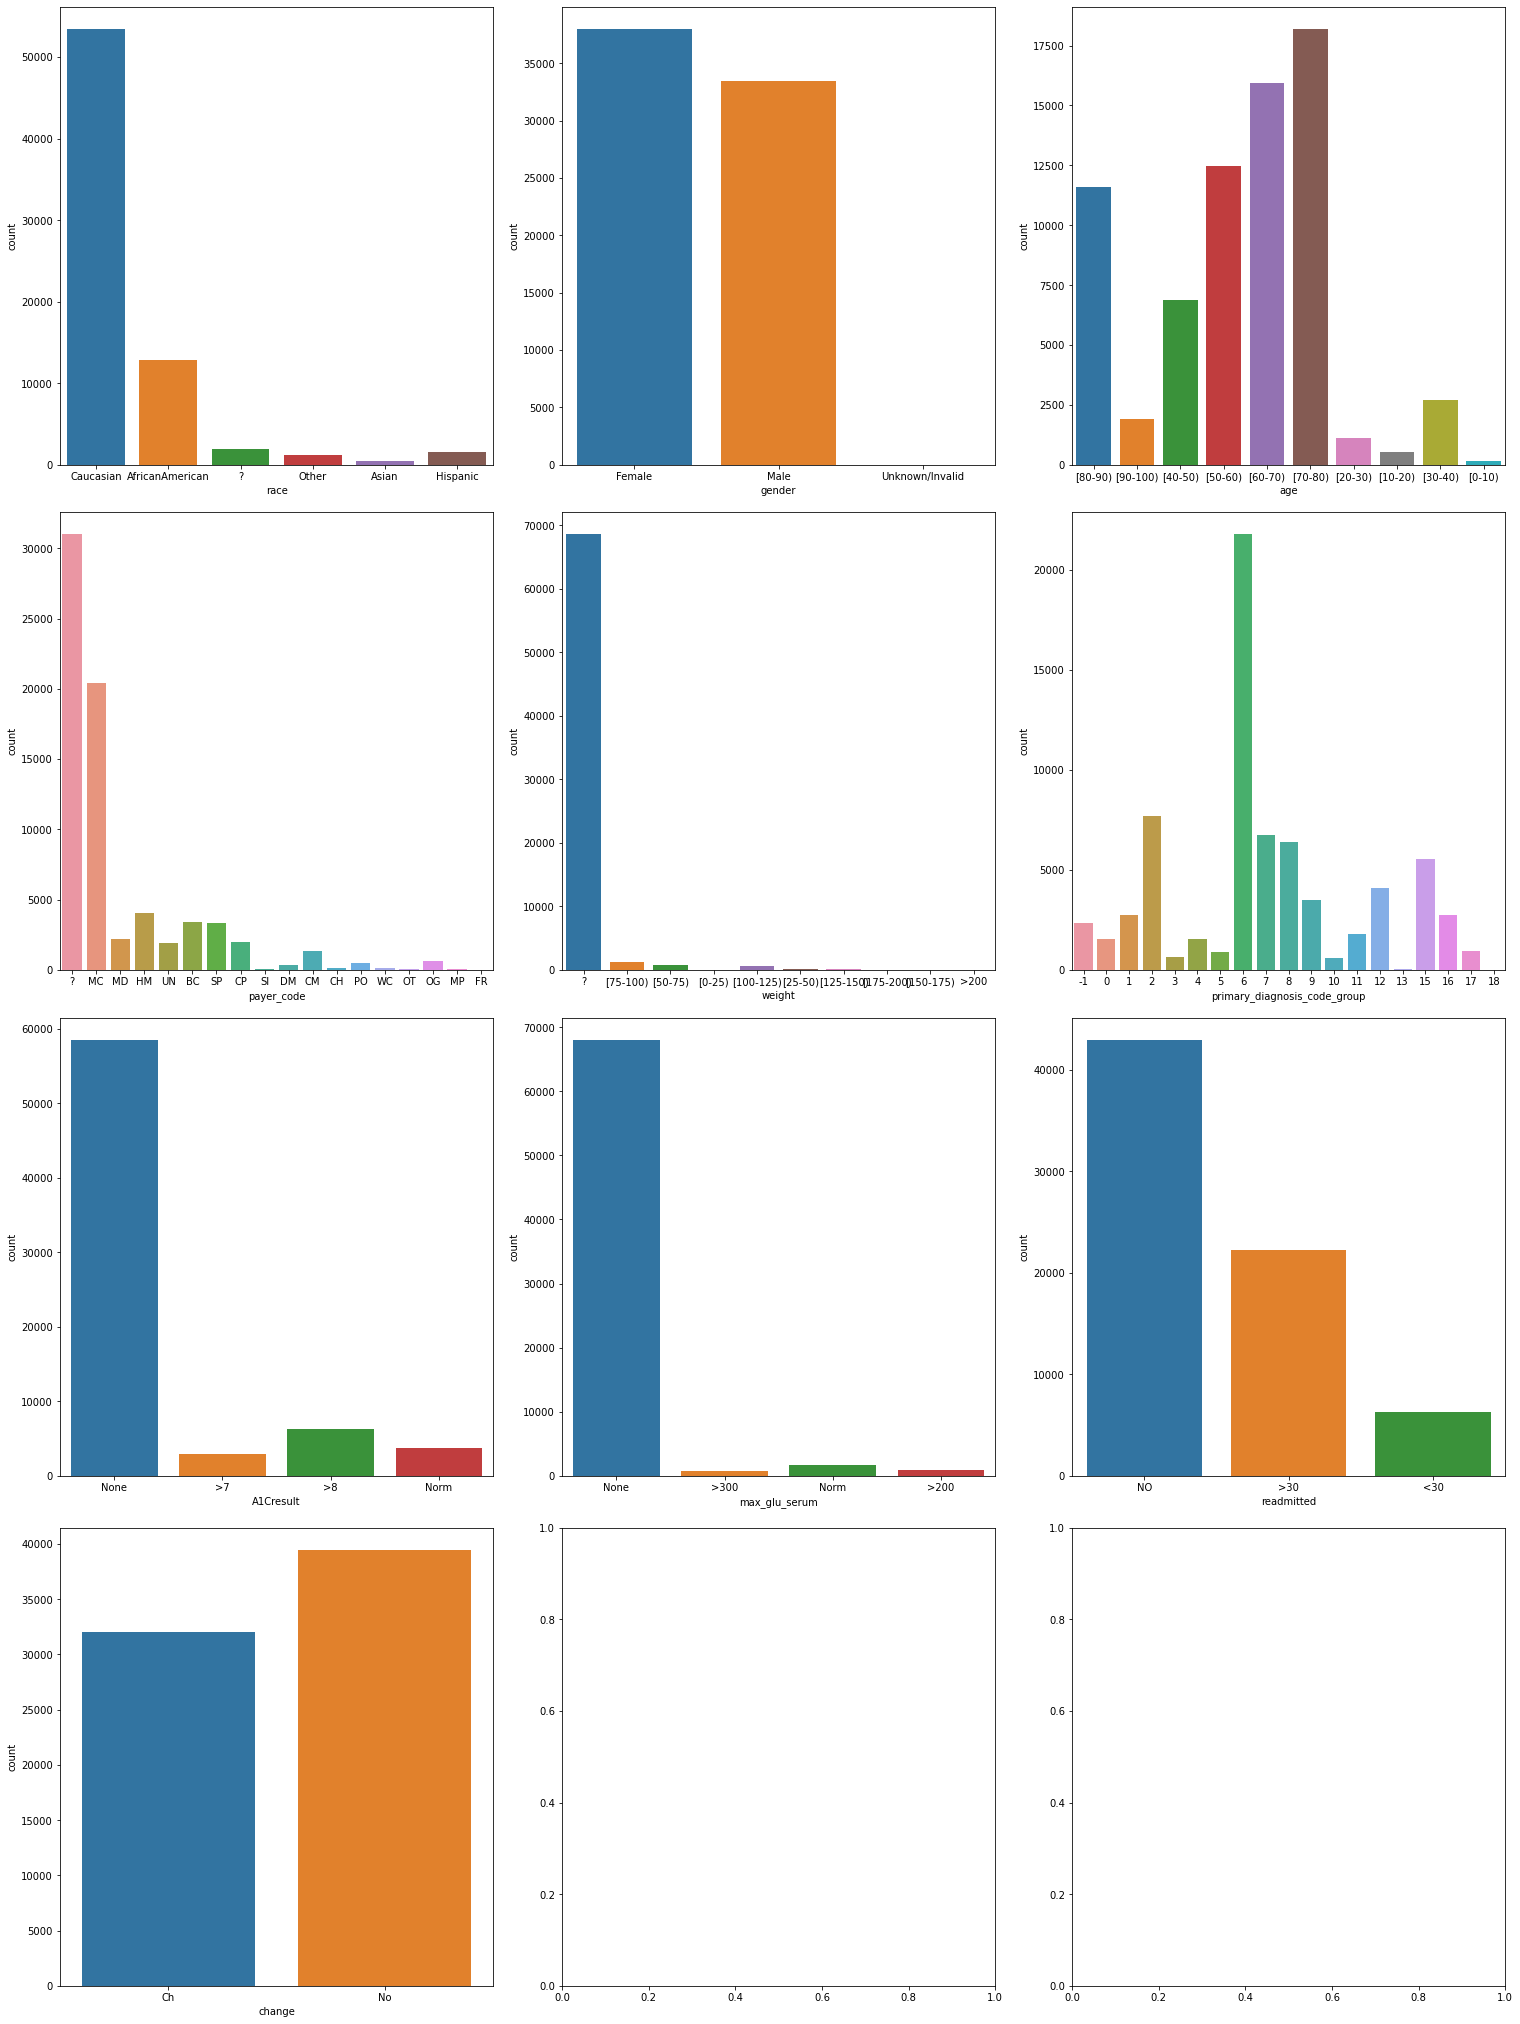

In [59]:
num_plots = len(potential_cat_cols)
total_cols = 3
total_rows = num_plots//total_cols+1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)

for i, var in enumerate(potential_cat_cols):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=agg_drug_df, ax=axs[row][pos])

Based on the count plots below, in addition to the required categorical columns, we will select categorical columns a count value of each categorical value is relatively close

In [60]:
selected_cols_categorical = ['primary_diagnosis_code_group', 'change', 'readmitted']

**Select numeric columns**

Based on the histogram plots below, we will select numeric columns with a wide range of data

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:3

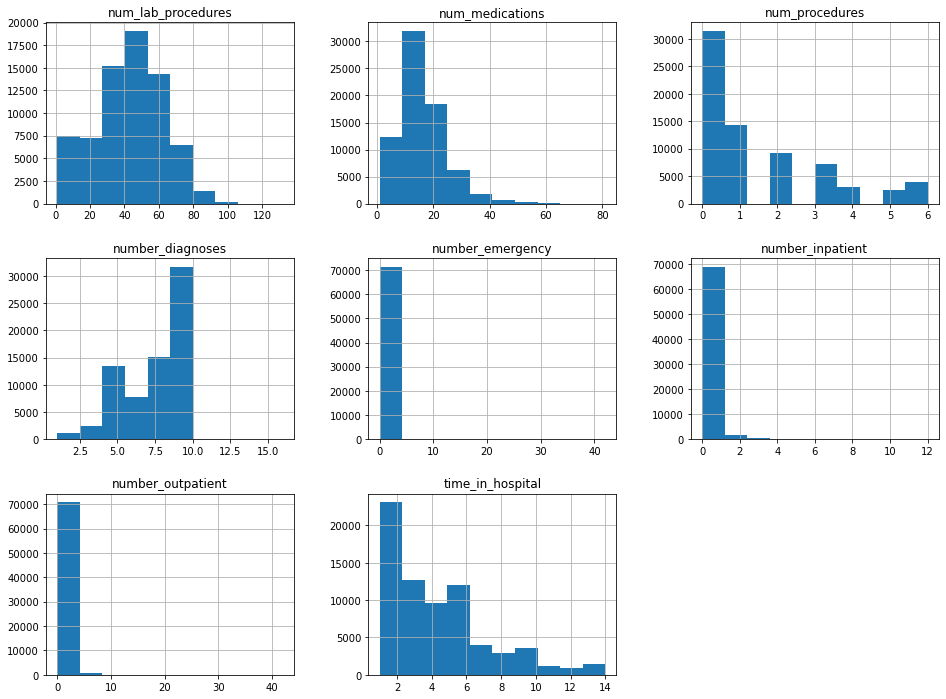

In [61]:
agg_drug_df[cols_numerics].hist(figsize=(16,12));

In [62]:
selected_cols_numerics = [
     'num_lab_procedures',
     'num_medications',
     'num_procedures',
     'number_diagnoses',
]

In [63]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
# required_demo_col_list = ['race', 'gender', 'age']
# student_categorical_col_list = [ "feature_A", "feature_B", .... ] + required_demo_col_list + ndc_col_list
# student_numerical_col_list = [ "feature_A", "feature_B", .... ]
# PREDICTOR_FIELD = ''

'\nPlease update the list to include the features you think are appropriate for the model \nand the field that we will be using to train the model. There are three required demographic features for the model \nand I have inserted a list with them already in the categorical list. \nThese will be required for later steps when analyzing data splits and model biases.\n'

In [64]:
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = selected_cols_categorical + required_demo_col_list + ndc_col_list
student_numerical_col_list = selected_cols_numerics
PREDICTOR_FIELD = 'time_in_hospital'

In [65]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [66]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

In [67]:
selected_features_df.head()

,patient_nbr,time_in_hospital,primary_diagnosis_code_group,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glyburide,Insulin,Metformin,Miglitol,Nateglinide,Pioglitazole,Repaglinide,Rosiglitazone,Tolazamide,Tolbutamide,num_lab_procedures,num_medications,num_procedures,number_diagnoses
0,48330783,13,6,Ch,NO,Caucasian,Female,[80-90),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,28,2,8
1,63555939,12,6,Ch,NO,Caucasian,Female,[90-100),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,33,18,3,8
2,42519267,1,1,Ch,NO,Caucasian,Male,[40-50),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51,8,0,5
3,89869032,9,2,No,>30,AfricanAmerican,Female,[40-50),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47,17,2,9
4,82637451,3,6,No,>30,Caucasian,Male,[50-60),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,16,6,9


### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

Inspect data to find missing values

In [68]:
selected_features_df.isna().sum().sort_values(ascending=False)

Insulin                         17247
Pioglitazole                    17247
Acarbose                        17247
Glimepiride                     17247
Glipizide                       17247
Glyburide                       17247
Metformin                       17247
Miglitol                        17247
Nateglinide                     17247
Repaglinide                     17247
Rosiglitazone                   17247
Tolazamide                      17247
Tolbutamide                     17247
race                                0
change                              0
primary_diagnosis_code_group        0
time_in_hospital                    0
readmitted                          0
number_diagnoses                    0
gender                              0
age                                 0
num_procedures                      0
num_lab_procedures                  0
num_medications                     0
patient_nbr                         0
dtype: int64

In [69]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [70]:
processed_df.sample(10)

,patient_nbr,time_in_hospital,primary_diagnosis_code_group,change,readmitted,race,gender,age,Acarbose,Glimepiride,Glipizide,Glyburide,Insulin,Metformin,Miglitol,Nateglinide,Pioglitazole,Repaglinide,Rosiglitazone,Tolazamide,Tolbutamide,num_lab_procedures,num_medications,num_procedures,number_diagnoses
51154,44117919,1.0,6,Ch,NO,AfricanAmerican,Male,[40-50),0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55,4,0,5
71116,55420065,4.0,10,No,NO,AfricanAmerican,Female,[20-30),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,18,1,6
31336,107575956,2.0,15,Ch,NO,Caucasian,Male,[50-60),0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,12,0,5
11105,19610082,2.0,9,No,NO,Hispanic,Female,[50-60),nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,20,16,2,4
59631,6475221,3.0,-1,Ch,>30,Caucasian,Male,[60-70),0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45,19,6,9
16323,20943999,8.0,6,Ch,NO,Caucasian,Male,[70-80),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,45,39,6,7
35441,77375961,3.0,2,Ch,>30,Caucasian,Female,[50-60),0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26,20,1,9
71448,187923560,3.0,6,No,NO,Caucasian,Male,[50-60),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,24,6,5
25020,33930,7.0,1,Ch,NO,AfricanAmerican,Female,[80-90),0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,40,15,3,5
35905,41861430,4.0,2,Ch,>30,Caucasian,Male,[70-80),0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,43,20,2,8


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [71]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [72]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [73]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

#### Inspect the 'race' data

race
?                   1165
AfricanAmerican     7701
Asian                297
Caucasian          32167
Hispanic             878
Other                703
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


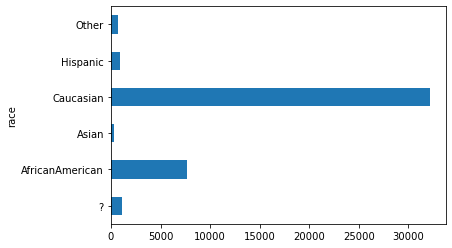

In [74]:
show_group_stats_viz(d_train, ['race']);

race
?                    378
AfricanAmerican     2667
Asian                 93
Caucasian          10619
Hispanic             315
Other                232
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


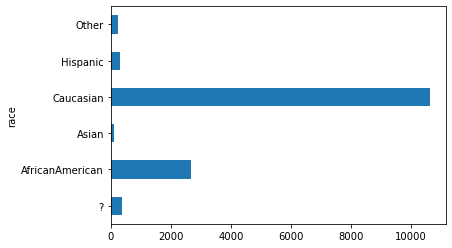

In [75]:
show_group_stats_viz(d_val, ['race']);

race
?                    405
AfricanAmerican     2519
Asian                107
Caucasian          10705
Hispanic             324
Other                243
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


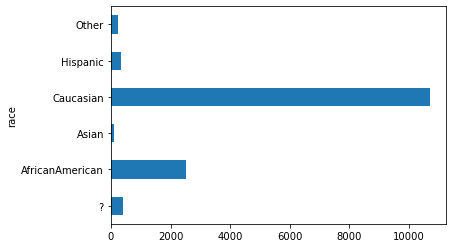

In [76]:
show_group_stats_viz(d_test, ['race']);

#### Inspect the 'gender' data

gender
Female             22845
Male               20064
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


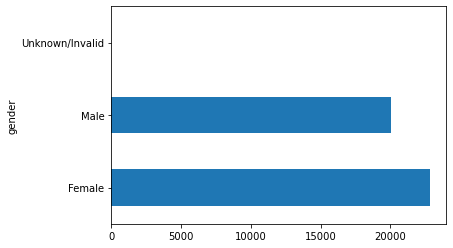

In [77]:
show_group_stats_viz(d_train, ['gender']);

gender
Female    7535
Male      6769
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


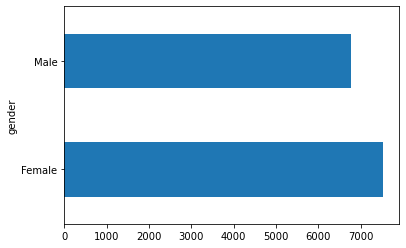

In [78]:
show_group_stats_viz(d_val, ['gender']);

gender
Female             7645
Male               6657
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


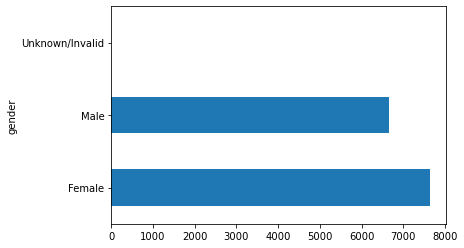

In [79]:
show_group_stats_viz(d_test, ['gender']);

#### Inspect the 'age' data

age
[0-10)         82
[10-20)       307
[20-30)       643
[30-40)      1611
[40-50)      4177
[50-60)      7442
[60-70)      9603
[70-80)     10966
[80-90)      6926
[90-100)     1154
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


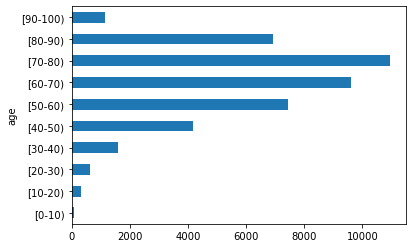

In [80]:
show_group_stats_viz(d_train, ['age']);

age
[0-10)        34
[10-20)      115
[20-30)      240
[30-40)      547
[40-50)     1352
[50-60)     2523
[60-70)     3194
[70-80)     3578
[80-90)     2319
[90-100)     402
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


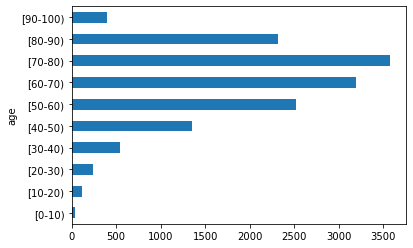

In [81]:
show_group_stats_viz(d_val, ['age']);

age
[0-10)        38
[10-20)      113
[20-30)      244
[30-40)      541
[40-50)     1349
[50-60)     2501
[60-70)     3163
[70-80)     3666
[80-90)     2344
[90-100)     344
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


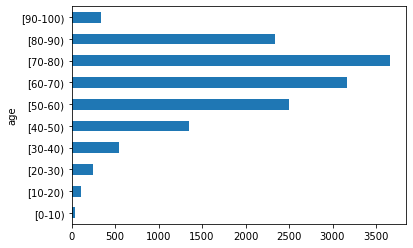

In [82]:
show_group_stats_viz(d_test, ['age']);

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10717
2.0     12397
3.0     12701
4.0      9567
5.0      6839
6.0      5171
7.0      3999
8.0      2919
9.0      1990
10.0     1558
11.0     1241
12.0      955
13.0      795
14.0      669
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


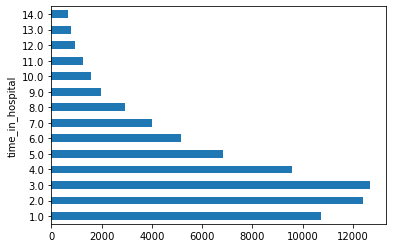

In [83]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6497
2.0     7430
3.0     7603
4.0     5828
5.0     4082
6.0     3064
7.0     2374
8.0     1791
9.0     1202
10.0     862
11.0     748
12.0     525
13.0     509
14.0     396
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


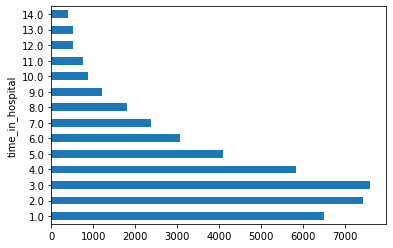

In [84]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2073
2.0     2487
3.0     2538
4.0     1916
5.0     1417
6.0     1029
7.0      819
8.0      568
9.0      365
10.0     337
11.0     255
12.0     211
13.0     150
14.0     138
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


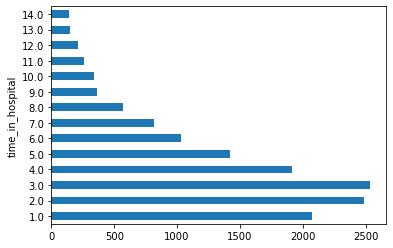

In [85]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             38025
Male               33490
Unknown/Invalid        3
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


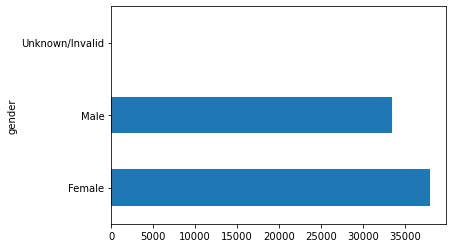

In [86]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             22845
Male               20064
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


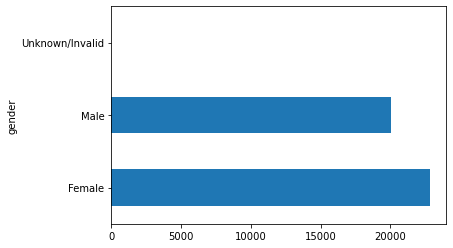

In [87]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female             7645
Male               6657
Unknown/Invalid       1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


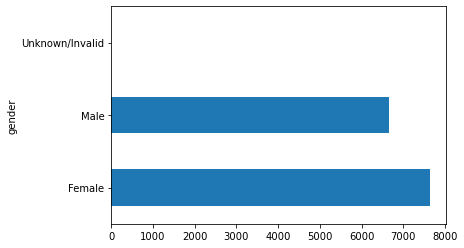

In [88]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [89]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [90]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [91]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

In [92]:
vocab_file_list

['./diabetes_vocab/primary_diagnosis_code_group_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/readmitted_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Insulin_vocab.txt',
 './diabetes_vocab/Metformin_vocab.txt',
 './diabetes_vocab/Miglitol_vocab.txt',
 './diabetes_vocab/Nateglinide_vocab.txt',
 './diabetes_vocab/Pioglitazole_vocab.txt',
 './diabetes_vocab/Repaglinide_vocab.txt',
 './diabetes_vocab/Rosiglitazone_vocab.txt',
 './diabetes_vocab/Tolazamide_vocab.txt',
 './diabetes_vocab/Tolbutamide_vocab.txt']

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [93]:
student_categorical_col_list

['primary_diagnosis_code_group',
 'change',
 'readmitted',
 'race',
 'gender',
 'age',
 'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Insulin',
 'Metformin',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole',
 'Repaglinide',
 'Rosiglitazone',
 'Tolazamide',
 'Tolbutamide']

In [94]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 20 in primary_diagnosis_code_group is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_group_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in change is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/change_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in readmitted is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/readmitted_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in age is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 4 in Acarbose is inferred from the number of elements in t

In [95]:
tf_cat_col_list

[IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code_group', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_group_vocab.txt', vocabulary_size=20, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='change', vocabulary_file='./diabetes_vocab/change_vocab.txt', vocabulary_size=3, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='readmitted', vocabulary_file='./diabetes_vocab/readmitted_vocab.txt', vocabulary_size=4, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./diabetes_vocab/race_vocab.txt', vocabulary_size=7, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='gender', vocabulary_file='./diabetes_v

In [96]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code_group', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_group_vocab.txt', vocabulary_size=20, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]], shape=(128, 21), dtype=float32)


# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [97]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [98]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [99]:
student_numerical_col_list

['num_lab_procedures', 'num_medications', 'num_procedures', 'number_diagnoses']

In [100]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [101]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f7f36c33290>, mean=42.95374146489245, std=19.999120917995572))

tf.Tensor(
[[ 0.21052632]
 [-0.42105263]
 [-2.1052632 ]
 [ 1.3684211 ]
 [ 0.2631579 ]
 [ 1.2105263 ]
 [-1.6842105 ]
 [-0.5263158 ]
 [-0.68421054]
 [ 1.0526316 ]
 [-0.2631579 ]
 [ 0.10526316]
 [ 0.5263158 ]
 [ 0.36842105]
 [ 0.84210527]
 [ 1.0526316 ]
 [ 0.10526316]
 [ 0.15789473]
 [ 0.47368422]
 [ 1.2105263 ]
 [-0.84210527]
 [ 0.05263158]
 [ 0.31578946]
 [ 1.1052631 ]
 [ 2.1578948 ]
 [ 1.4210526 ]
 [ 0.5263158 ]
 [-1.6315789 ]
 [ 1.2631578 ]
 [-0.6315789 ]
 [-2.1578948 ]
 [-0.15789473]
 [ 0.7894737 ]
 [ 1.2105263 ]
 [ 0.05263158]
 [-2.0526316 ]
 [ 0.6315789 ]
 [-0.42105263]
 [-0.21052632]
 [ 0.        ]
 [-2.0526316 ]
 [ 0.31578946]
 [ 1.5263158 ]
 [-0.15789473]
 [ 0.15789473]
 [-0.31578946]
 [ 0.10526316]
 [-0.21052632]
 [-0.052631

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [102]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [103]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(64, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [104]:
num_epoch = 50
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=num_epoch)

Train for 336 steps, validate for 112 steps
Epoch 1/50
336/336 [==============================] - 17s 50ms/step - loss: 25.8519 - mse: 25.6637 - val_loss: 18.8661 - val_mse: 18.4194
Epoch 2/50
336/336 [==============================] - 10s 29ms/step - loss: 16.4121 - mse: 15.7577 - val_loss: 14.3441 - val_mse: 13.3880
Epoch 3/50
336/336 [==============================] - 10s 29ms/step - loss: 13.0334 - mse: 12.1416 - val_loss: 13.0795 - val_mse: 12.3167
Epoch 4/50
336/336 [==============================] - 11s 31ms/step - loss: 11.8848 - mse: 10.9883 - val_loss: 11.8483 - val_mse: 11.0912
Epoch 5/50
336/336 [==============================] - 10s 29ms/step - loss: 11.4683 - mse: 10.6193 - val_loss: 11.0916 - val_mse: 10.3790
Epoch 6/50
336/336 [==============================] - 10s 30ms/step - loss: 10.5203 - mse: 9.7599 - val_loss: 10.1310 - val_mse: 9.4123
Epoch 7/50
336/336 [==============================] - 10s 29ms/step - loss: 9.7137 - mse: 8.9761 - val_loss: 9.3433 - val_mse: 8.5

In [105]:
def plot_history(history):
    
    ### YOUR CODE HERE
    fig, m_axs = plt.subplots(1,2, figsize = (12, 4))
    m_axs[0].plot(history.history['loss'], label = "Training Loss")
    m_axs[0].plot(history.history['val_loss'], label = "Validation Loss")
    m_axs[0].set(xlabel='Epoch', ylabel='Loss')
    m_axs[0].set_yscale('log')
    m_axs[0].legend()
    m_axs[0].set_title('Training Loss vs Validation Loss');
    
    m_axs[1].plot(history.history['mse'], label = "Training MSE")
    m_axs[1].plot(history.history['val_mse'], label = "Validation MSE")
    m_axs[1].set(xlabel='Epoch', ylabel='MSE')
    m_axs[1].legend()
    m_axs[1].set_title('Training MSE vs Validation MSE');

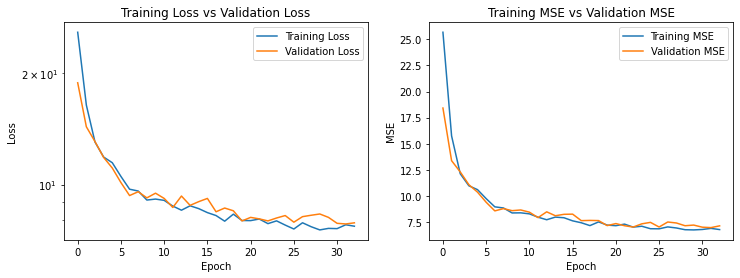

In [106]:
plot_history(history)

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [107]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [108]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [109]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [110]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,1.786901,4.0,2.717369,0.708075
1,1.784666,10.0,5.762934,0.705237
2,1.343508,6.0,3.866199,0.705000
3,1.163613,5.0,3.581864,0.705835
4,3.037720,5.0,5.181738,0.704496


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [111]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [112]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [113]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,85845150,Male,AfricanAmerican,4.0,0,0
1,10254051,Female,Caucasian,10.0,1,1
2,161136248,Female,Caucasian,6.0,0,1
3,44204553,Female,AfricanAmerican,5.0,0,1
4,6800724,Male,Caucasian,5.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [114]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

In [115]:
# AUC, F1, precision and recall
# Summary

In [116]:
y_true = pred_test_df['label_value'].values 
y_pred = pred_test_df['score'].values

In [117]:
accuracy_score(y_true, y_pred)

0.6988044466195903

In [118]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.99      0.81      9014
           1       0.90      0.21      0.34      5289

    accuracy                           0.70     14303
   macro avg       0.79      0.60      0.57     14303
weighted avg       0.76      0.70      0.63     14303



In [119]:
roc_auc_score(y_true, y_pred)

0.5973104357361291

**Answer:**

Since the goal of this project is to build a predictive model that can identify which type of patients the company should focus their efforts testing this drug on, we would like our model to have a **higher precision** so we have more confidence in a positive result when predicting patients who are likely to be hospitalized at least 5 days so control the costs of this clinical trial. This will prevent us from incurring additional costs for administering this drug to the patient and monitoring as oppose to a higher recall model which could potentially predict a negative case as positive.

What are some areas of improvement for future iterations?
* To improve this more further, we can consider 
 * performing additional feature engineering tasks for the 'primary_diagnosis_code' and 'other_diagnosis_codes' to reduce cardinality and include them during training
 * Instead of selecting only the first encounter, we can considerusing an aggregated encounter data and use it during training



# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [120]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [1215]}


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [121]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

In [122]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

### True Positive Rate Disparity

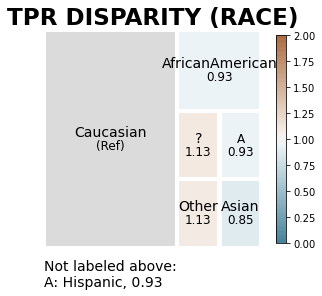

In [123]:
tpr_disparity_race = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='race')

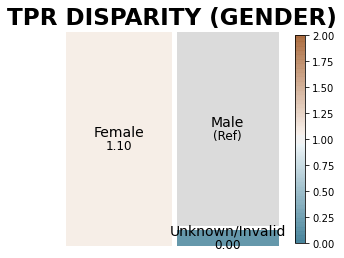

In [124]:
tpr_disparity_gender = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='gender')

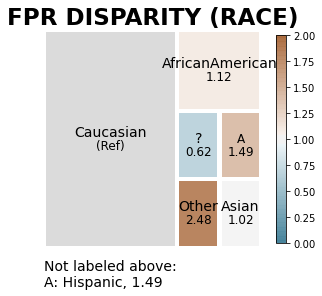

In [125]:
fpr_disparity_race = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')

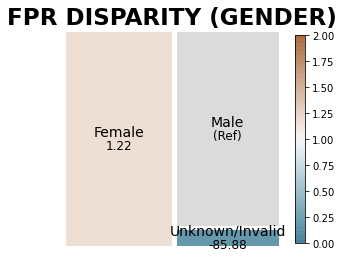

In [126]:
fpr_disparity_gender = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

**Answer:**

From the disparity plots above, we can see that
* The females are 22 times more likely to have false positives than the reference male class
* We saw a much smaller FPR for the Hispanic's group. This might mean that there might be special characteristics in the Hispanic's group which help this model to learn better.

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [127]:
# Reference group fairness plot

### Absolute Value Fairness Determination
- Red = False/Not Fair
- Green = True/Fair

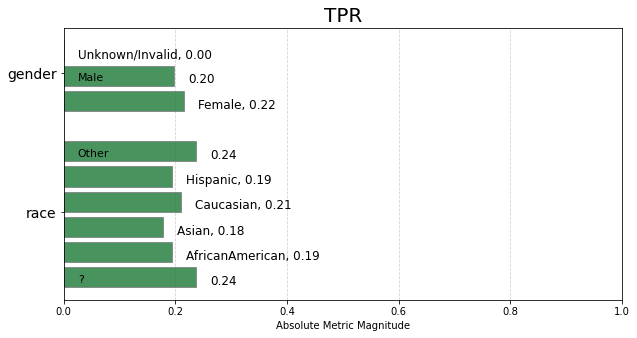

In [128]:
tpr_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr', title=True)

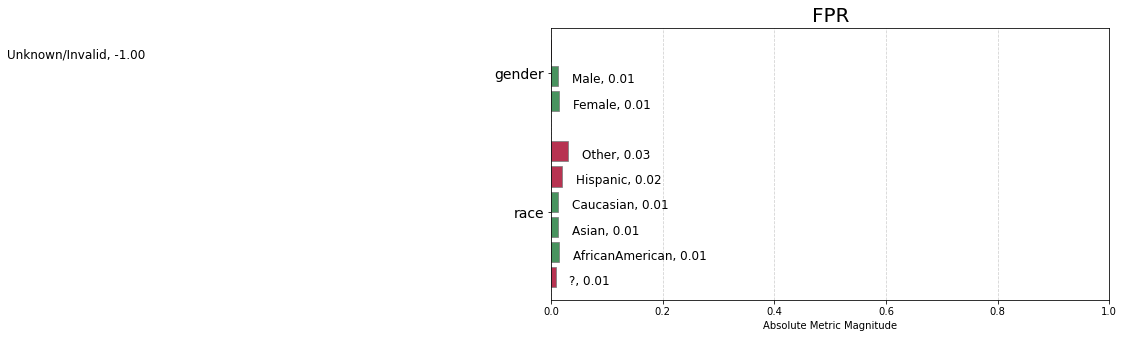

In [129]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

**Answers:** 

The plots above show that
* There is no apparent disparity with different genders
* The 'Hispanic' group is in a less 'fair' group in terms of TPR and FPR metrics

In [130]:
!jupyter nbconvert --to html 'student_project.ipynb'

[NbConvertApp] Converting notebook student_project.ipynb to html
[NbConvertApp] Writing 934643 bytes to student_project.html
